In [1]:
import numpy as np
import sys
sys.path.insert(1,'C:/Users/UASAL-OPTICS/Desktop/poke/') # One day I'll actually package poke!
import poke.poke_core as pol
from astropy.io import fits
import astropy.units as u
import poppy as poppy
# Try load and plot
elt_pupil = fits.open('ELT_Pupil_256.fits')[0].data

In [2]:
# Load Refractive Indices
index_pth = "C:/Users/UASAL-OPTICS/Box/PolarizationGSMT/refractive_indices.csv"
data = np.genfromtxt(index_pth,delimiter=',',skip_header=2)[:,1:]
wlen_microns = data[:,0]
N_Ag = data[:,1] - 1j*data[:,2]
N_Al = data[:,3] - 1j*data[:,4]
N_SiN = data[:,5] - 1j*data[:,6]

# Film thickness for ELT
t_SiN = 55e-10 # 55 angstroms

# pick a band!
i = 0
n2 = [(N_SiN[i],t_SiN),(N_Ag[i])] 

In [3]:
# Load ELT pupils aoi
aoi_m1 = fits.open('ELT_aoi_surf0.fits')[0].data
aoi_m2 = fits.open('ELT_aoi_surf1.fits')[0].data
aoi_m3 = fits.open('ELT_aoi_surf2.fits')[0].data
aoi_m4 = fits.open('ELT_aoi_surf3.fits')[0].data
aoi_m5 = fits.open('ELT_aoi_surf4.fits')[0].data

In [4]:
def ComputeDiattenuationAndRetardance(aoi,film,wl):

    rs,rp = pol.FresnelCoefficients(aoi,1,film,wavelength=wl)

    D = (np.abs(rs)**2 - np.abs(rp)**2) / (np.abs(rs)**2 + np.abs(rp)**2)
    R = np.angle(rs) - np.angle(rp)

    return D,R 

DM1,RM1 = ComputeDiattenuationAndRetardance(aoi_m1,n2,wlen_microns[i]*1e-6)
DM2,RM2 = ComputeDiattenuationAndRetardance(aoi_m2,n2,wlen_microns[i]*1e-6)
DM3,RM3 = ComputeDiattenuationAndRetardance(aoi_m3,n2,wlen_microns[i]*1e-6)
DM4,RM4 = ComputeDiattenuationAndRetardance(aoi_m4,n2,wlen_microns[i]*1e-6)
DM5,RM5 = ComputeDiattenuationAndRetardance(aoi_m5,n2,wlen_microns[i]*1e-6)


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_26496\810730123.py:16: RuntimeWarning: invalid value encountered in true_divide
  im = ax[i,0].imshow(D[i]*elt_pupil/elt_pupil,interpolation='nearest')
C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_26496\810730123.py:23: RuntimeWarning: invalid value encountered in true_divide
  im = ax[i,1].imshow(R[i]*elt_pupil/elt_pupil,interpolation='nearest')


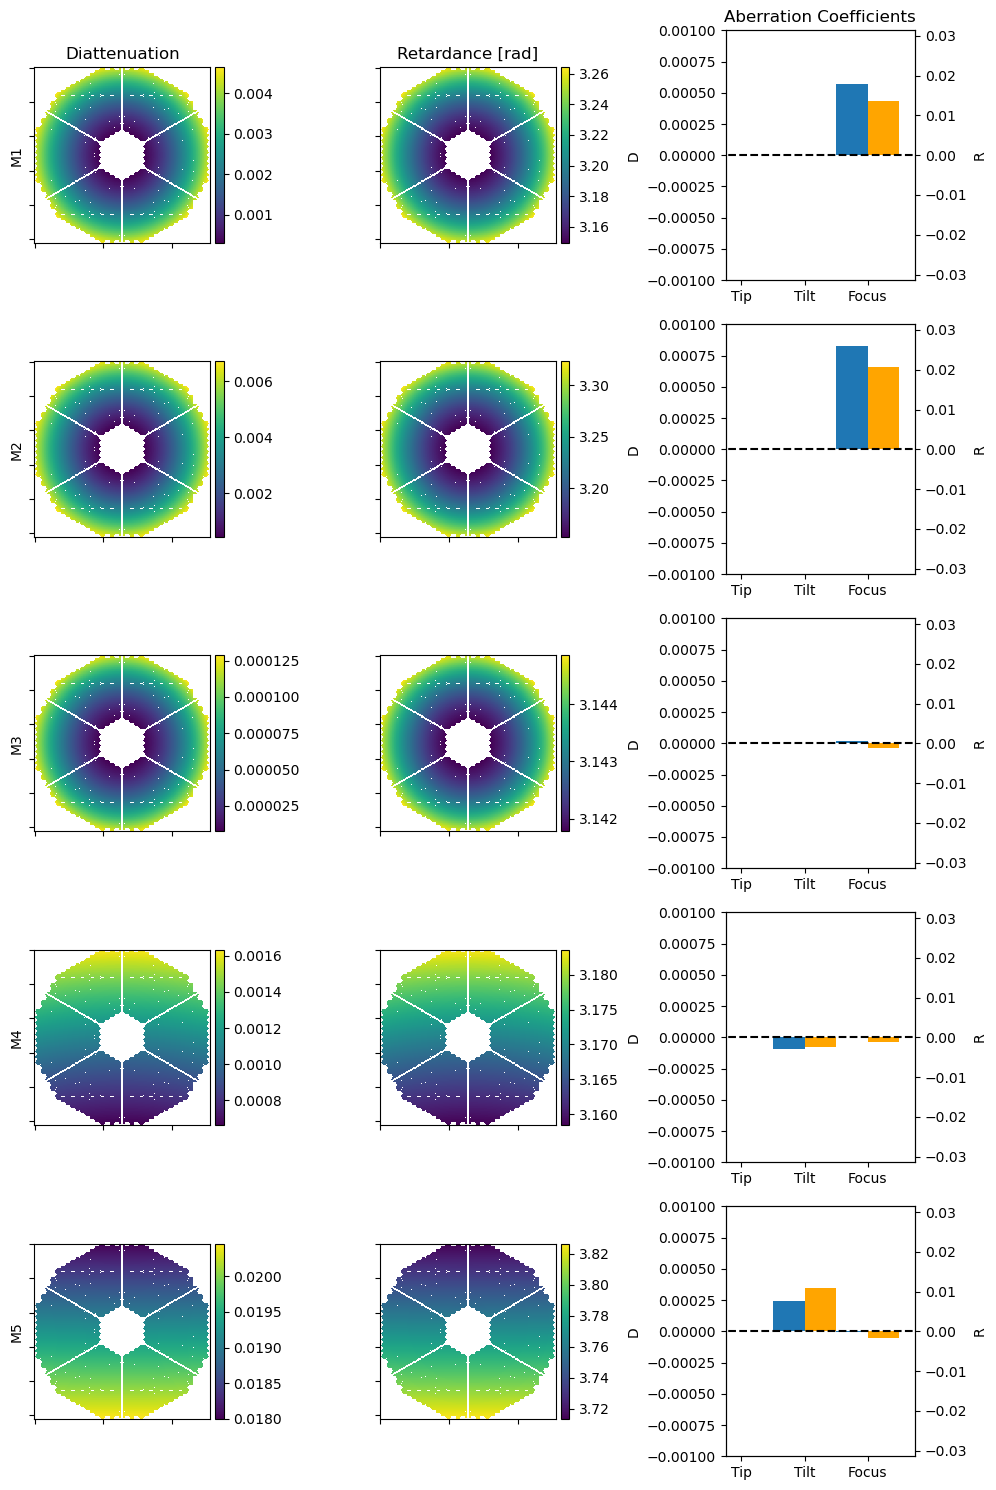

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

dx = np.arange(1,4,1)
rx = np.arange(1,4,1) + 0.5

D = [DM1,DM2,DM3,DM4,DM5]
R = [RM1,RM2,RM3,RM4,RM5]

fig,ax = plt.subplots(ncols=3,nrows=5,figsize=[10,15])
ax[0,0].set_title('Diattenuation')
ax[0,1].set_title('Retardance [rad]')
ax[0,2].set_title('Aberration Coefficients')
for i in range(5):

    im = ax[i,0].imshow(D[i]*elt_pupil/elt_pupil,interpolation='nearest')
    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im,cax=cax)
    ax[i,0].tick_params(labelbottom=False,labelleft=False)
    ax[i,0].set_ylabel('M{}'.format(i+1))

    im = ax[i,1].imshow(R[i]*elt_pupil/elt_pupil,interpolation='nearest')
    divider = make_axes_locatable(ax[i,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im,cax=cax)
    ax[i,1].tick_params(labelbottom=False,labelleft=False)

    ax[i,2].bar(dx,ComputePolAbCoeffs(D[i]),label='Diattenuation',width=0.5)
    ax[i,2].set_ylim([-1e-3,1e-3])
    ax[i,2].set_xticks(dx + 0.25)
    ax[i,2].set_xticklabels(['Tip','Tilt','Focus'])
    ax[i,2].set_ylabel('D')
    ax[i,2].set_xlim([1,4])

    axtwin = ax[i,2].twinx()
    axtwin.bar(rx,ComputePolAbCoeffs(R[i]),label='Retardance',color='orange',width=0.5)
    axtwin.plot(np.linspace(0,4,len(dx)),np.zeros(dx.shape),linestyle='dashed',color='black')
    axtwin.set_ylim([-np.pi/100,np.pi/100])
    axtwin.set_ylabel('R')

# fig.legend()
fig.tight_layout()
plt.show()

C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_26496\181900152.py:30: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow((map - z0*Z0 - z1*Z1 - z2*Z2 - z3*Z3)/Z0)


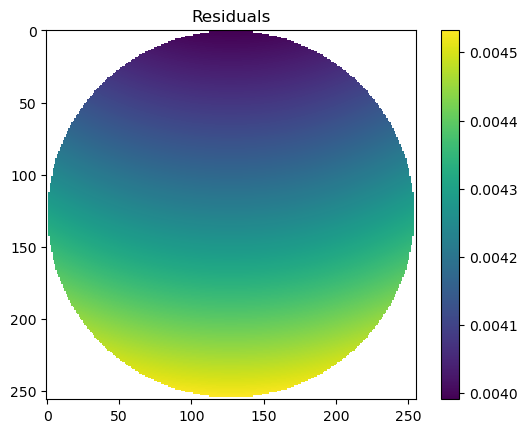

(-3.076847180901246e-19, 0.0004795030491017171, -1.5011924072942618e-05)

In [22]:
# Try out poppy zernike decomposition
def ComputePolAbCoeffs(map):

    dim = map.shape[0]

    x = np.linspace(-1,1,dim)
    x,y = np.meshgrid(x,x)

    # Piston
    Z0 = np.zeros(x.shape)#[x**2 + y**2 <=1]
    Z0[x**2 + y**2 <=1] = 1

    # Tip 
    Z1 = 2*x*Z0#[x**2 + y**2 <=1]

    # Tilt
    Z2 = 2*y*Z0#[x**2 + y**2 <=1]

    # Focus
    Z3 = np.sqrt(3)*(2*(x**2 + y**2)-1)*Z0#[x**2 + y**2 <=1]

    # Coefficient
    z0 = np.mean(Z0*map)
    z1 = np.mean(Z1*map)
    z2 = np.mean(Z2*map)
    z3 = np.mean(Z3*map)

    plt.figure()
    plt.title('Residuals')
    plt.imshow((map - z0*Z0 - z1*Z1 - z2*Z2 - z3*Z3)/Z0)
    plt.colorbar()
    plt.show()

    return z1,z2,z3

ComputePolAbCoeffs(DM5)

In [ ]:
plt.imshow()